In [9]:
import numpy as np
from obp.dataset import linear_reward_function
from obp.dataset import (SyntheticBanditDatasetWithActionEmbeds, 
                        linear_reward_function)
from obp.ope import RegressionModel
from ope import run_ope
import pandas as pd
from pandas import DataFrame
from policy import gen_eps_greedy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [10]:
n_actions_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

result_df_list = []
for n_action in n_actions_list:
    ## define a dataset class
    # change the list to the action list
    estimated_policy_value_list = []

    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_action,
        dim_context=10,
        beta=-1,
        reward_type="continuous",
        # Number of categories (cardinality) per each category dimension
        n_cat_per_dim=10, 
        latent_param_mat_dim=5, 
        # Number of action/item category dimensions.
        n_cat_dim=3,
        n_unobserved_cat_dim=0,
        n_deficient_actions=int(n_action * 0.0),
        reward_function=linear_reward_function,
        reward_std=2.5,
        random_state=12345,
    )
    
    
    ### test bandit data is used to approximate the ground-truth policy value
    test_bandit_data = dataset.obtain_batch_bandit_feedback(
        n_rounds=5000
        )

    # Generate an evaluation policy via the epsilon-greedy rule
    action_dist_test = gen_eps_greedy(
        expected_reward=test_bandit_data["expected_reward"],
        is_optimal=True,
        eps=0.05,
    )

    # actulal policy value e.g., 0.26909277388815384
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_bandit_data["expected_reward"],
        action_dist=action_dist_test,
    )
    
    
    
    # for _ in range(100):
    for _ in tqdm(range(20), desc = f"n_action: {n_action}"):
        ## generate validation data
        val_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=5000
            )

        ## make decisions on validation data
        action_dist_val = gen_eps_greedy(
            expected_reward=val_bandit_data["expected_reward"],
            is_optimal=True,
            eps=0.05,
        )

        ## OPE using validation data
        
        # Machine learning model to estimate the reward function (:math:`q(x,a):= \mathbb{E}[r|x,a]`).
        reg_model = RegressionModel(
            # Number of actions.
            n_actions=dataset.n_actions,
            # Context vectors characterizing actions (i.e., a vector representation or an embedding of each action).
            action_context=val_bandit_data["action_context"],
            # A machine learning model used to estimate the reward function.
            base_model=RandomForestRegressor(
                n_estimators=10,
                max_samples=0.8,
                random_state=12345 + _
            ),
        )

        # Fit the regression model on given logged bandit data and estimate the expected rewards on the same data.
        # Returns
        #  q_hat: array-like, shape (n_rounds, n_actions, len_list)
        #  Expected rewards of new data estimated by the regression model.
        estimated_rewards = reg_model.fit_predict(
            context=val_bandit_data["context"],  # context; x
            action=val_bandit_data["action"],  # action; a
            reward=val_bandit_data["reward"],  # reward; r
            # Number of folds in the cross-fitting procedure.
            n_folds=2,
            random_state=12345 + _
        )
        
        # get the estimated values of several estimators e.g., DM, IPS, DR, MIPS
        estimated_policy_values = run_ope(
            # observed data D
            val_bandit_data=val_bandit_data,
            # evaluation policy \pi(a|x)
            action_dist_val=action_dist_val,
            # \hat{q(x, a)}
            estimated_rewards=estimated_rewards,
            embed_selection=False,
        )
        
        
        # IPS
        # create \pi_e(a_i|x_i)
        pscore_evaluation = np.zeros(val_bandit_data["n_rounds"])
        for i in range(val_bandit_data["n_rounds"]):
            pscore_evaluation[i] = action_dist_val[i, val_bandit_data["action"][i]]
        # importance weight w(x_i, a_i)
        importance_weight = pscore_evaluation / val_bandit_data["pscore"]
        # IPS estimator
        V_IPS = np.mean(importance_weight * val_bandit_data["reward"])
        
        
        # DM estimator
        V_DM = np.mean(np.sum(action_dist_val * estimated_rewards, axis = 1))
        
        
        # DR
        # q_xi_ai   
        q_xi_ai = np.zeros(val_bandit_data["n_rounds"])
        for i in range(val_bandit_data["n_rounds"]):
            q_xi_ai[i] = estimated_rewards[i, val_bandit_data["action"][i]]
        # DR estimator
        V_DR = np.mean(np.sum(action_dist_val * estimated_rewards, axis = 1) + importance_weight * (val_bandit_data["reward"] - q_xi_ai))


        # MIPS
        # P(e|x, a) transition kernel
        p_e_a = val_bandit_data["p_e_a"]
        # behavior policy \pi_b(a|x) and evaluation policy \pi_e(a|x)
        # change the shape of them so that we can do matrix multiplication later
        pi_b = np.zeros((len(val_bandit_data["pi_b"]), len(val_bandit_data["pi_b"][0])))
        action_dist = np.zeros((len(val_bandit_data["pi_b"]), len(val_bandit_data["pi_b"][0])))
        for i in range(len(val_bandit_data["pi_b"])):
            for j in range(len(val_bandit_data["pi_b"][0])):
                pi_b[i][j] = val_bandit_data["pi_b"][i][j][0]
                action_dist[i][j] = action_dist_val[i][j][0]
        # n
        n = val_bandit_data["n_rounds"]
        # e
        action_embed = val_bandit_data["action_embed"]
        # initialize P(e|x, pi_b) and P(e|x, pi_e) by 1
        p_e_pi_b = np.ones(n)
        p_e_pi_e = np.ones(n)
        # for each d in [0, 1, 2, \cdots, d_e - 1]
        for d in np.arange(p_e_a.shape[-1]):
            # P(e|x, pi_b)
            p_e_pi_b_d = pi_b[np.arange(n), :] @ p_e_a[:, :, d]
            p_e_pi_b *= p_e_pi_b_d[np.arange(n), action_embed[:, d]]
            # P(e|x, pi_e)
            p_e_pi_e_d = action_dist[np.arange(n), :] @ p_e_a[:, :, d]
            p_e_pi_e *= p_e_pi_e_d[np.arange(n), action_embed[:, d]]
        # marginalize importance weight w(x_i, e_i)
        w_x_e = p_e_pi_e / p_e_pi_b

        V_MIPS_true = np.mean(w_x_e * val_bandit_data["reward"])


        # MDR1 (wrong version of MDR without unbiasedness)
        V_MDR1 = V_DM + V_MIPS_true - np.mean(w_x_e * q_xi_ai)
        V_MDR1
        
        
        
        # MDR2 (MDR with unbiasedness)
        # first estimate the q_xi_ai_ei
        # modify the shape of action listto be used
        modefied_action = [[a] for a in val_bandit_data["action"]]

        # define the regression target
        y = val_bandit_data["reward"]

        # define the regressor
        X = np.hstack((val_bandit_data["context"], modefied_action, val_bandit_data["action_embed"]))

        from sklearn.linear_model import Ridge
        # define the Ridge regression
        reg = Ridge(alpha=1.5)

        # training the model
        reg.fit(X, y)

        # q_xi_ai_ei    
        q_xi_ai_ei = np.zeros(val_bandit_data["n_rounds"])
        for i in range(val_bandit_data["n_rounds"]):
            # q_xi_ai_ei[i] = estimated_rewards_x_a_e[i, val_bandit_data["action"][i], i]
            X_test = np.hstack((val_bandit_data["context"][i], modefied_action[i], val_bandit_data["action_embed"][i]))
            q_xi_ai_ei[i] = reg.predict([X_test])
            
        # MDR2
        # This is the MDR that I propose in the paper
        V_MDR2 = V_DM + V_MIPS_true - np.mean(w_x_e * q_xi_ai_ei)
        V_MDR2
               
        
        # add MDR to the dictionary of estimator and estimated value 
        estimated_policy_values["MDR1"] = V_MDR1
        estimated_policy_values["MDR2"] = V_MDR2
        
        estimated_policy_value_list.append(estimated_policy_values)

    
    
    ## summarize results
    result_df = (
        DataFrame(DataFrame(estimated_policy_value_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "est", 0: "value"})
    )
    result_df["n_action"] = n_action
    result_df["se"] = (result_df.value - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
    for est_ in sample_mean["est"]:
        estimates = result_df.loc[result_df["est"] == est_, "value"].values
        mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
        mean_estimates = np.ones_like(estimates) * mean_estimates
        result_df.loc[result_df["est"] == est_, "bias"] = (
            policy_value - mean_estimates
        ) ** 2
        result_df.loc[result_df["est"] == est_, "variance"] = (
            estimates - mean_estimates
        ) ** 2
    result_df_list.append(result_df)


# aggregate all results
result_df = pd.concat(result_df_list).reset_index(level=0)

n_action: 10:   0%|          | 0/20 [00:00<?, ?it/s]/Users/s23599/anaconda3/envs/hanjuku/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
n_action: 10:   5%|▌         | 1/20 [00:00<00:16,  1.13it/s]/Users/s23599/anaconda3/envs/hanjuku/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
n_action: 10:  10%|█         | 2/20 [00:01<00:15,  1.19it/s]/Users/s23599/anaconda3/envs/hanjuku/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless y

In [ ]:
# extrect the true MDR with unbiasedness guarantee
result_df_2 = result_df.copy()
result_df_2['est'].mask(result_df_2['est'] == 'MDR2', 'MDR', inplace=True)
result_df_2['est'].mask(result_df_2['est'] == 'MIPS', 'MIPS (false)', inplace=True)
result_df_2['est'].mask(result_df_2['est'] == 'MIPS (true)', 'MIPS', inplace=True)

Text(0, 0.5, 'mean squared error (MSE)')

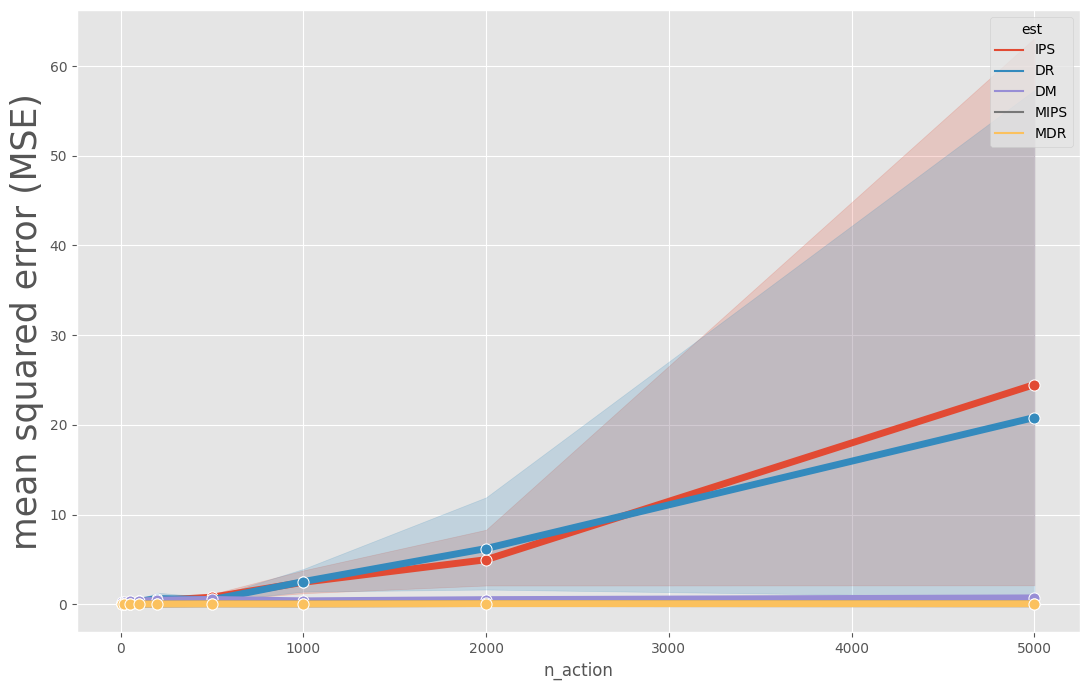

In [ ]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(11, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    marker="o",
    markersize=8,
    markers=True,
    x="n_action",
    y="se",
    hue="est",
    ax=ax,
    data=result_df_2.query("(est == 'IPS' or est == 'DR' or est == 'DM' or est == 'MIPS' or est == 'MDR')"),
)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)

Text(0, 0.5, 'Bias')

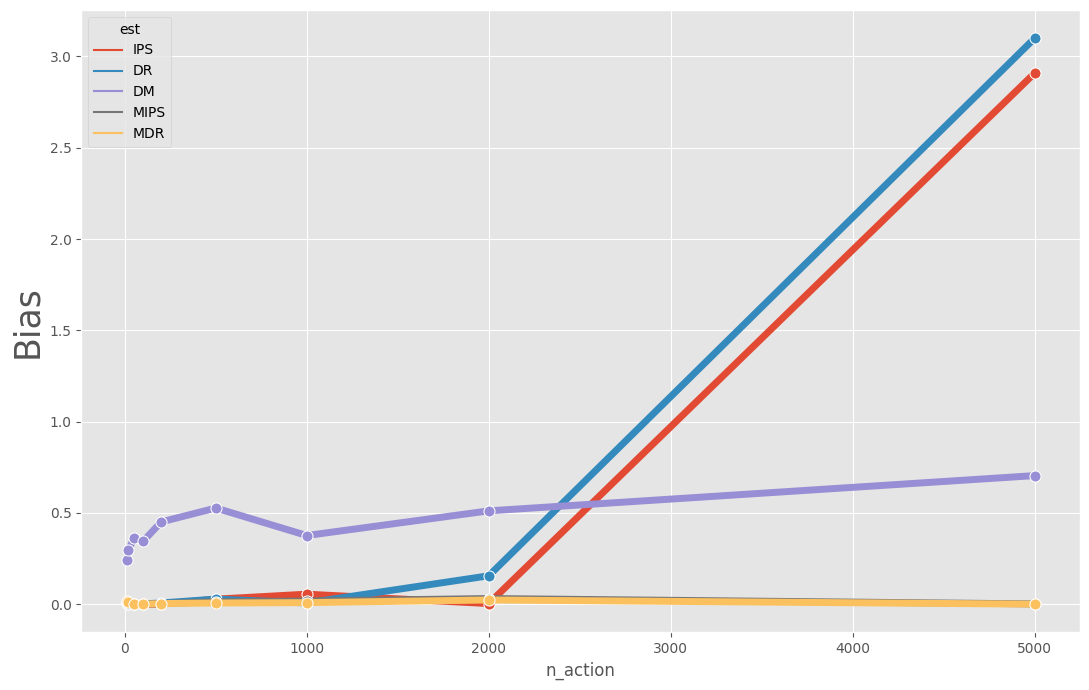

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    marker="o",
    markersize=8,
    markers=True,
    x="n_action",
    y="bias",
    hue="est",
    ax=ax,
    data=result_df_2.query("(est == 'IPS' or est == 'DR' or est == 'DM' or est == 'MIPS' or est == 'MDR')"),
)
ax.set_ylabel("Bias", fontsize=25)

Text(0, 0.5, 'Variance')

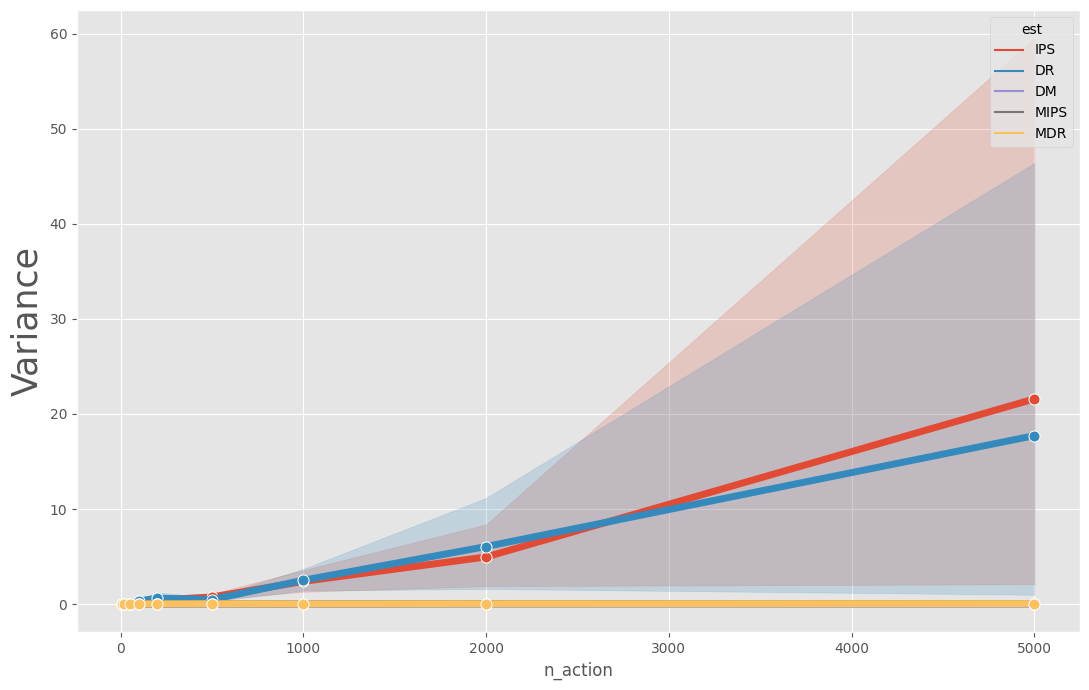

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    marker="o",
    markersize=8,
    markers=True,
    x="n_action",
    y="variance",
    hue="est",
    ax=ax,
    data=result_df_2.query("(est == 'IPS' or est == 'DR' or est == 'DM' or est == 'MIPS' or est == 'MDR')"),
)
# yaxis
ax.set_ylabel("Variance", fontsize=25)

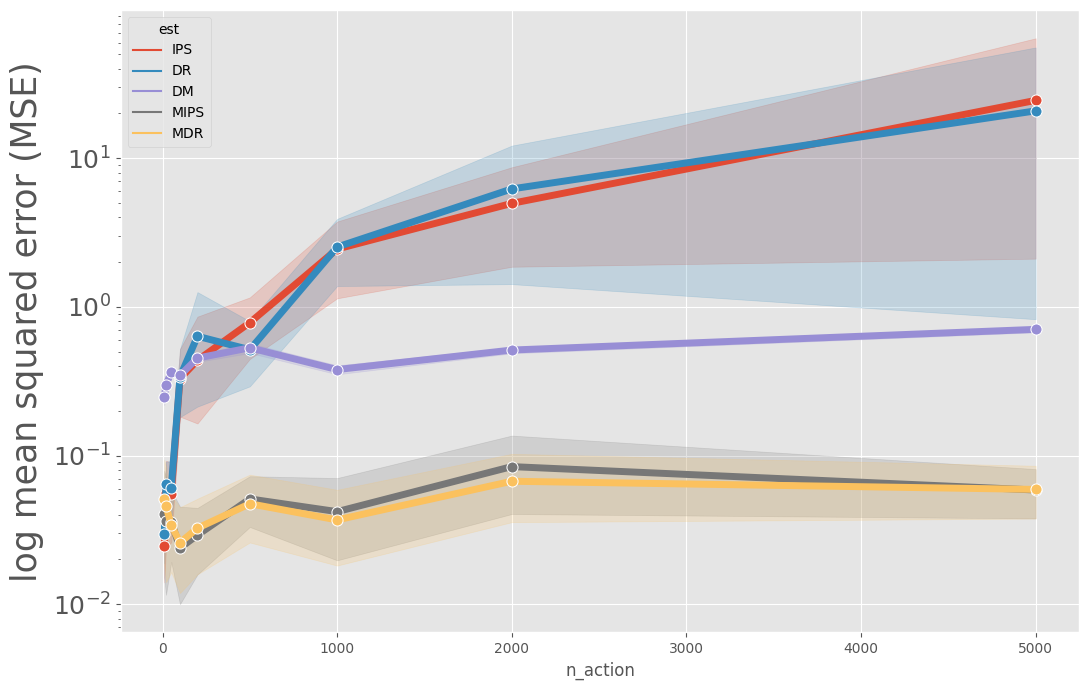

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    marker="o",
    markersize=8,
    markers=True,
    x="n_action",
    y="se",
    hue="est",
    ax=ax,
    data=result_df_2.query("(est == 'IPS' or est == 'DR' or est == 'DM' or est == 'MIPS' or est == 'MDR')"),
)

# yaxis
ax.set_yscale("log")
ax.set_ylabel("log mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)

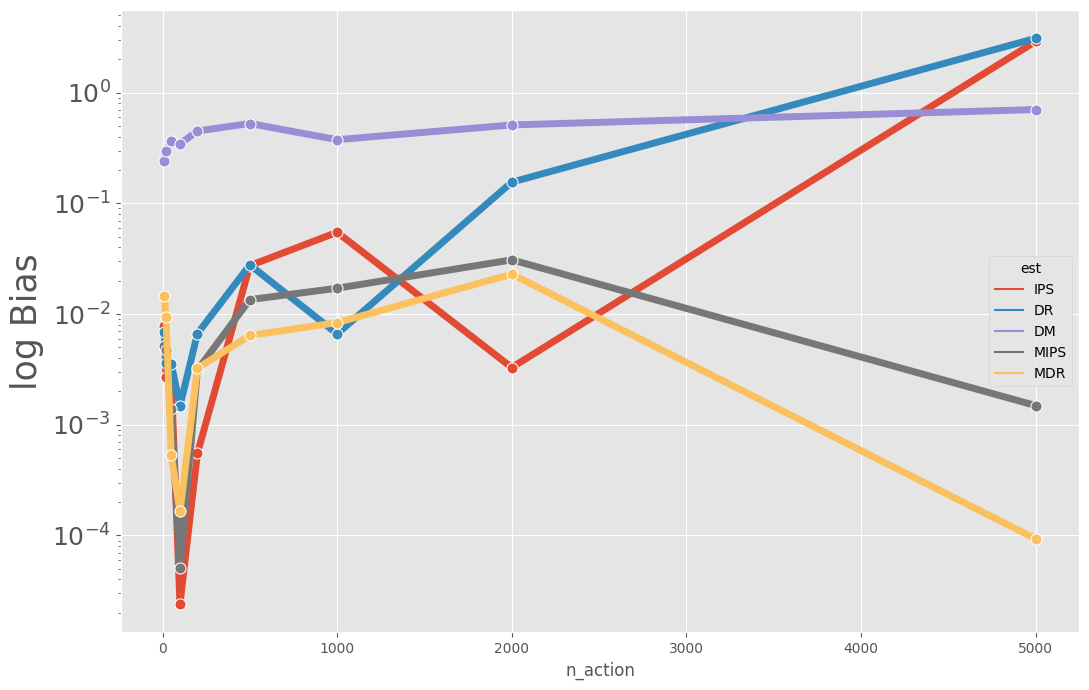

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    marker="o",
    markersize=8,
    markers=True,
    x="n_action",
    y="bias",
    hue="est",
    ax=ax,
    data=result_df_2.query("(est == 'IPS' or est == 'DR' or est == 'DM' or est == 'MIPS' or est == 'MDR')"),
)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("log Bias", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)

Text(0, 0.5, 'log Variance')

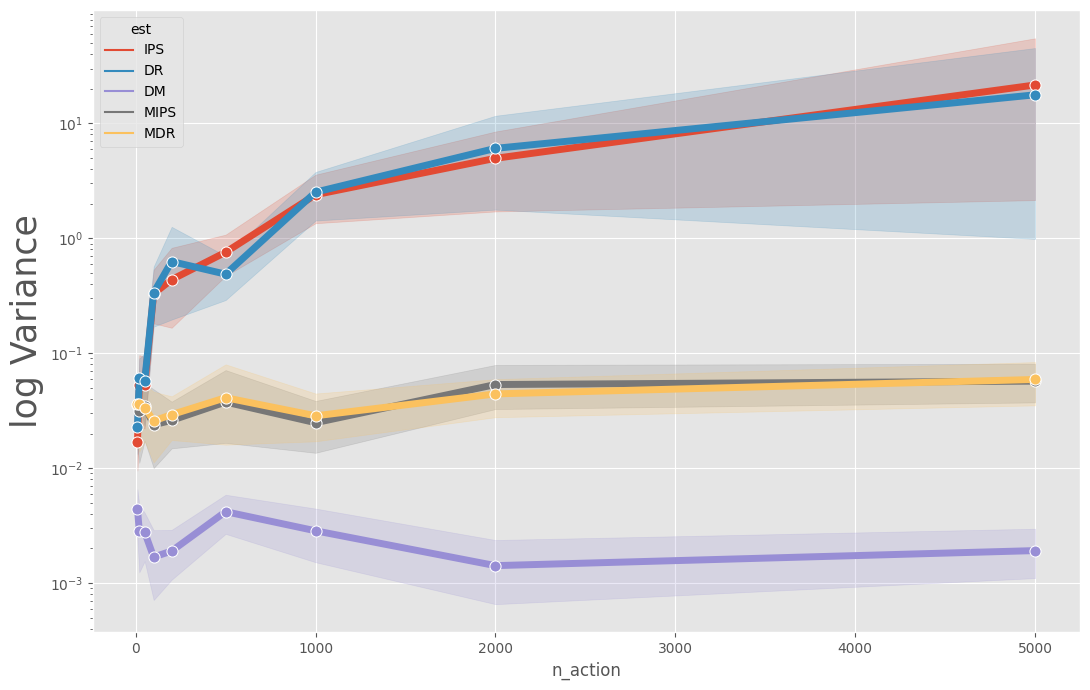

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    marker="o",
    markersize=8,
    markers=True,
    x="n_action",
    y="variance",
    hue="est",
    ax=ax,
    data=result_df_2.query("(est == 'IPS' or est == 'DR' or est == 'DM' or est == 'MIPS' or est == 'MDR')"),
)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("log Variance", fontsize=25)
# ax.tick_params(axis="y", labelsize=18)